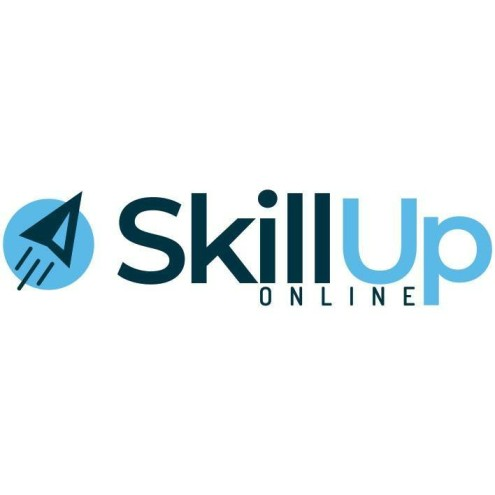

# **Detección de fraudes con tarjetas de crédito**

Enlace al dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

### Importa las bibliotecas necesarias

In [187]:
# Librerias necesarias para el proyecto algunas no se utilizaran, pero me gusta agregarlas.

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import time

# Clasificadores 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Otras librerias a usar
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

# Evitar Advertencias
import warnings
warnings.filterwarnings("ignore")

### Importa y organiza el dataset

In [7]:
# Organizar los datos en un dataframe
df = pd.read_csv('creditcard.csv')

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Limpia los datos

a. Valores perdidos

In [47]:
df.isnull().sum().max()

0

<Axes: >

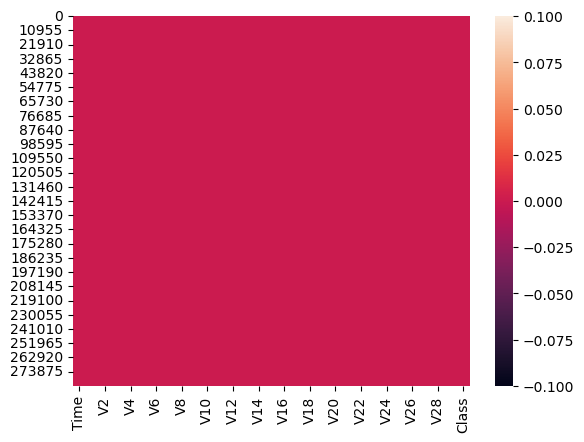

In [49]:
sns.heatmap(df.isnull())

Los datos se muestran completamente limpios en todo su contenido.

b. Datos duplicados

In [56]:
df.duplicated().sum()

1081

### Analiza los datos

<font color='green' fontsize=18>Pregunta 1: ¿Cuál es el porcentaje de transacciones fraudulentas en el dataset?</font>

In [67]:
num_fraudulentas = df['Class'].sum()
total_operaciones = df['Class'].count()
porcentaje_operaciones_fraudulentas = (num_fraudulentas / total_operaciones) * 100
print(f'Número de operaciones fraudulentas: {num_fraudulentas}')
print(f'Total de operaciones: {total_operaciones}')
print(f'Porcentaje de operaciones fraudulentas: {porcentaje_operaciones_fraudulentas:.2f}%')

Número de operaciones fraudulentas: 492
Total de operaciones: 284807
Porcentaje de operaciones fraudulentas: 0.17%


<font color='green' fontsize=18>Pregunta 2: ¿Cuál es el importe medio de las transacciones fraudulentas?</font>

In [71]:
operaciones_fraudulentas = df[df['Class'] == 1]
importe_medio_fraudulentas = operaciones_fraudulentas['Amount'].mean()
print(f'Importe medio de operaciones fraudulentas: {importe_medio_fraudulentas:.2f}')

Importe medio de operaciones fraudulentas: 122.21


### Visualiza los datos

<font color='green' fontsize=18>Pregunta 1: ¿Cuántas transacciones fraudulentas hay en comparación con las no fraudulentas? </font> (Utiliza un gráfico de barras)

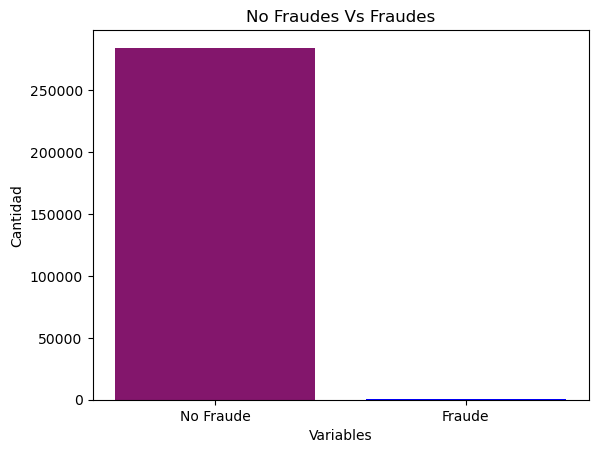

- Transacciones fraudulentas: 492
- Transacciones No fraudulentas: 284315


In [190]:
x_1 = np.count_nonzero(df['Class'] == 1)
y_1 = len(df) - x_1
etiquetas = ['No Fraude', 'Fraude']
alturas = [y_1, x_1]
plt.bar(etiquetas, alturas, color=['#83166C', 'Blue'])
plt.xlabel('Variables')
plt.ylabel('Cantidad')
plt.title('No Fraudes Vs Fraudes')
plt.show()
print(f'- Transacciones fraudulentas: {x_1}')
print(f'- Transacciones No fraudulentas: {y_1}')

<font color='blue' fontsize=18>DISTRIBUCIONES:</font> Al ver las distribuciones podemos tener una idea de qué tan sesgadas están estas características. Hay técnicas que pueden ayudar a que las distribuciones sean menos sesgadas y que se pudieran emplear, pero no es tema para esta evaluación.

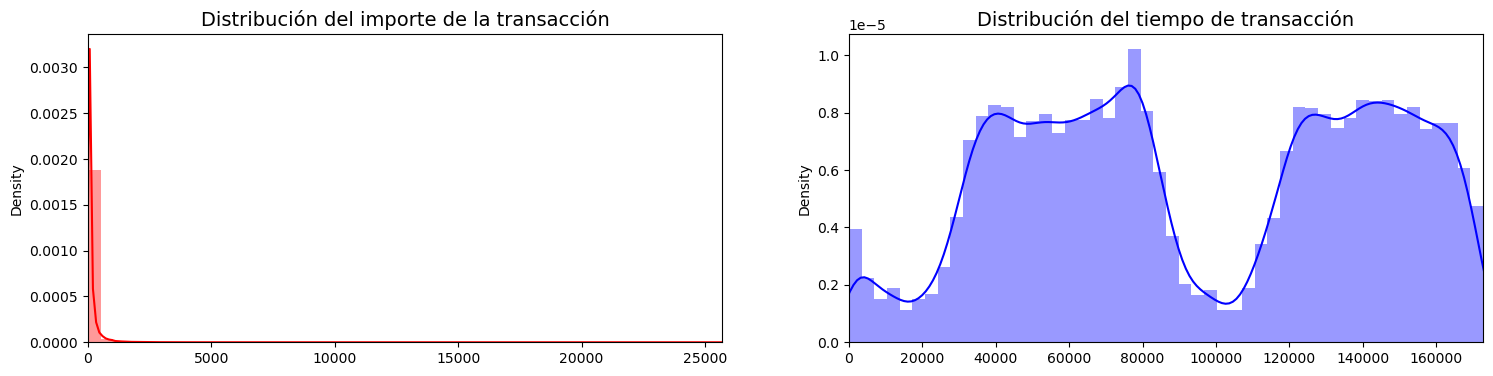

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribución del importe de la transacción', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribución del tiempo de transacción', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

<font color='green' fontsize=18>Pregunta 2: ¿Cuál es la distribución de los importes de las transacciones fraudulentas?</font> (Utiliza un histograma)

<font color='#A04000' fontsize=30>Primera Forma de presentar este grafico</font>

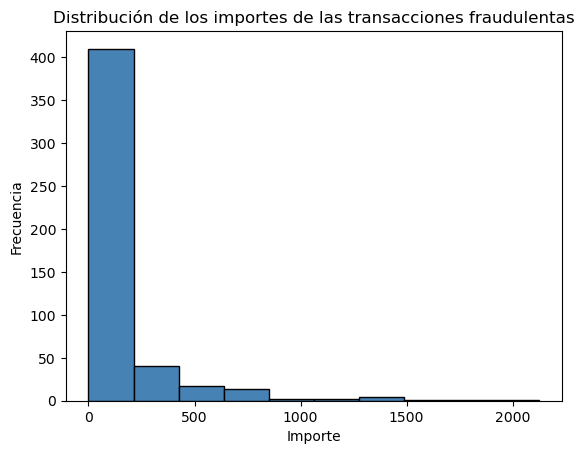

- Valor maximo de defraudado: 2125.87
- Promedio de monto defraudado: 122.21


In [75]:
# Filtrar las transacciones fraudulentas (Ya lo tenemos del ejercicio anterior)

operaciones_fraudulentas
max_valor = operaciones_fraudulentas['Amount'].max()
prmd_valor = operaciones_fraudulentas['Amount'].mean()

# Visualizar la distribución de los importes de las transacciones fraudulentas

plt.hist(operaciones_fraudulentas['Amount'], bins=10, color='#4682B4', edgecolor='black')
plt.title('Distribución de los importes de las transacciones fraudulentas')
plt.xlabel('Importe')
plt.ylabel('Frecuencia')
plt.show()

#Extras

print(f'- Valor maximo de defraudado: {max_valor}')
print(f'- Promedio de monto defraudado: {prmd_valor:.2f}')

<font color='#A04000' fontsize=30>Otra Forma de presentar este grafico</font>

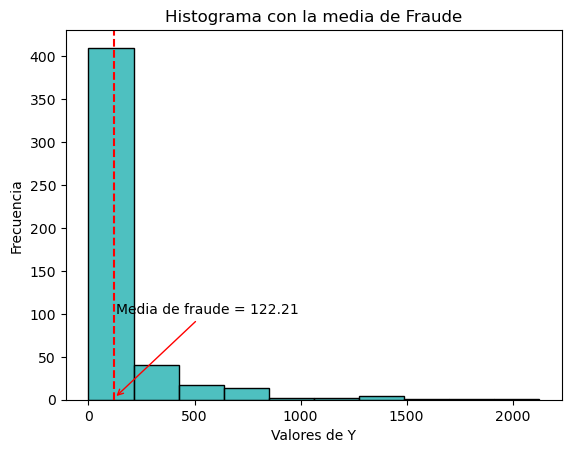

In [78]:
sns.histplot(operaciones_fraudulentas['Amount'], bins=10, kde=False, color='#13ABAB')
media_y = operaciones_fraudulentas['Amount'].mean()
plt.axvline(x=media_y, color='red', linestyle='--', label=f'Media = {media_y:.2f}')

plt.xlabel('Valores de Y')
plt.ylabel('Frecuencia')
plt.title('Histograma con la media de Fraude')
plt.annotate(f'Media de fraude = {media_y:.2f}', xy=(media_y, 2), xytext=(media_y + 10, 100), 
             arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

plt.show()

## Desarrollo y evaluación de modelos

### Separa del dataset

In [82]:
y = df["Class"]
x = df.drop("Class", axis=1)

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)

### Crea y evalúa los modelos

In [92]:
random_forest = RandomForestClassifier(max_depth=150, random_state=42)
random_forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=150, random_state=42)

In [100]:
x_pred = random_forest.predict(x_test)

In [143]:
labels = ['No Fraudulentas', 'Fraudulentas']
print(classification_report(y_test,x_pred, target_names=labels))

                 precision    recall  f1-score   support

No Fraudulentas       1.00      1.00      1.00     56847
   Fraudulentas       0.97      0.83      0.90       115

       accuracy                           1.00     56962
      macro avg       0.98      0.92      0.95     56962
   weighted avg       1.00      1.00      1.00     56962



In [116]:
exactitud = accuracy_score(y_test, x_pred)
exactitud_porcentaje = exactitud * 100
print(f"Exactitud del modelo: {exactitud_porcentaje:.2f}%")

Exactitud del modelo: 99.96%


<font color='#A04000' fontsize=26><strong>OTRA MANERA DE PRESENTAR LA MÉTRICA EN PORCENTAJES:</strong></font>

In [182]:
def calcular_metricas(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1sc = f1_score(y_true, y_pred)
    acsc = accuracy_score(y_true, y_pred)

    return recall * 100, precision * 100, f1sc * 100, acsc * 100

# Llamada a la función
p1, p2, p3, p4 = calcular_metricas(y_test, x_pred)

print('---' * 45)
print('Otras mediciones del modelo en porcentajes: \n')
print(f'Puntuación de recuperación: {p1:.2f}%'.format(recall_score(y_test, x_pred)))
print(f'Puntuación de precisión: {p2:.2f}%'.format(precision_score(y_test, x_pred)))
print(f'F1 Puntuación: {p3:.2f}%'.format(f1_score(y_test, x_pred)))
print(f'Puntuación de precisión: {p4:.2f}%'.format(accuracy_score(y_test, x_pred)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Otras mediciones del modelo en porcentajes: 

Puntuación de recuperación: 83.48%
Puntuación de precisión: 96.97%
F1 Puntuación: 89.72%
Puntuación de precisión: 99.96%
---------------------------------------------------------------------------------------------------------------------------------------


### <font color='#A04000' fontsize=26><strong>FIN DE LA EVALUACION FINAL. GRACIAS!!!</strong></font>